In [1]:
!apt-get install openjdk-11-jdk -qq > /dev/null
!pip install pyspark==3.5.1 -q


import pyspark
print("PySpark version:", pyspark.__version__)


PySpark version: 3.5.1


In [2]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .appName("movielens_analytics")
         .getOrCreate())

spark


In [6]:
!rm -rf data
!mkdir -p data

In [9]:
!unzip -q ml-100k.zip -d data/ml-100k
!ls data/ml-100k | head -20


replace data/ml-100k/ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: allbut.pl
mku.sh
ml-100k
README
u1.base
u1.test
u2.base
u2.test
u3.base
u3.test
u4.base
u4.test
u5.base
u5.test
ua.base
ua.test
ub.base
ub.test
u.data
u.genre


In [11]:
!ls data/ml-100k/ml-100k | head -30


allbut.pl
mku.sh
README
u1.base
u1.test
u2.base
u2.test
u3.base
u3.test
u4.base
u4.test
u5.base
u5.test
ua.base
ua.test
ub.base
ub.test
u.data
u.genre
u.info
u.item
u.occupation
u.user


In [12]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

# Şema tanımı (u.data dosyası için)
schema = StructType([
    StructField("user_id", IntegerType(), True),
    StructField("movie_id", IntegerType(), True),
    StructField("rating", IntegerType(), True),
    StructField("timestamp", IntegerType(), True),
])

# Veri okuma
ratings = (spark.read
           .option("delimiter", "\t")
           .schema(schema)
           .csv("data/ml-100k/u.data"))

ratings.show(5)
ratings.printSchema()


+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|    196|     242|     3|881250949|
|    186|     302|     3|891717742|
|     22|     377|     1|878887116|
|    244|      51|     2|880606923|
|    166|     346|     1|886397596|
+-------+--------+------+---------+
only showing top 5 rows

root
 |-- user_id: integer (nullable = true)
 |-- movie_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- timestamp: integer (nullable = true)



In [13]:
movies_schema = StructType([
    StructField("movie_id", IntegerType(), True),
    StructField("title", StringType(), True),
    StructField("release_date", StringType(), True),
    StructField("video_release_date", StringType(), True),
    StructField("imdb_url", StringType(), True),
])

movies = (spark.read
          .option("delimiter", "|")
          .schema(movies_schema)
          .csv("data/ml-100k/u.item"))

movies.select("movie_id", "title", "release_date").show(5, truncate=False)


+--------+-----------------+------------+
|movie_id|title            |release_date|
+--------+-----------------+------------+
|1       |Toy Story (1995) |01-Jan-1995 |
|2       |GoldenEye (1995) |01-Jan-1995 |
|3       |Four Rooms (1995)|01-Jan-1995 |
|4       |Get Shorty (1995)|01-Jan-1995 |
|5       |Copycat (1995)   |01-Jan-1995 |
+--------+-----------------+------------+
only showing top 5 rows



In [14]:
avg_ratings = ratings.groupBy("movie_id").avg("rating")

joined = (avg_ratings
          .join(movies, on="movie_id", how="inner")
          .select("title", "avg(rating)")
          .orderBy("avg(rating)", ascending=False))

joined.show(10, truncate=False)


+-------------------------------------------------+-----------+
|title                                            |avg(rating)|
+-------------------------------------------------+-----------+
|Someone Else's America (1995)                    |5.0        |
|Santa with Muscles (1996)                        |5.0        |
|Marlene Dietrich: Shadow and Light (1996)        |5.0        |
|Entertaining Angels: The Dorothy Day Story (1996)|5.0        |
|They Made Me a Criminal (1939)                   |5.0        |
|Saint of Fort Washington, The (1993)             |5.0        |
|Prefontaine (1997)                               |5.0        |
|Star Kid (1997)                                  |5.0        |
|Aiqing wansui (1994)                             |5.0        |
|Great Day in Harlem, A (1994)                    |5.0        |
+-------------------------------------------------+-----------+
only showing top 10 rows



In [15]:
joined.write.mode("overwrite").csv("data/output/top_rated_movies.csv", header=True)


In [16]:
user_avg = ratings.groupBy("user_id").avg("rating").orderBy("avg(rating)", ascending=False)
user_avg.show(10)


+-------+-----------------+
|user_id|      avg(rating)|
+-------+-----------------+
|    849|4.869565217391305|
|    688|4.833333333333333|
|    507|4.724137931034483|
|    628|4.703703703703703|
|    928|           4.6875|
|    118|4.661971830985915|
|    907|4.571428571428571|
|    686|4.563380281690141|
|    427|4.548387096774194|
|    565|4.542857142857143|
+-------+-----------------+
only showing top 10 rows



In [17]:
active_users = ratings.groupBy("user_id").count().orderBy("count", ascending=False)
active_users.show(10)


+-------+-----+
|user_id|count|
+-------+-----+
|    405|  737|
|    655|  685|
|     13|  636|
|    450|  540|
|    276|  518|
|    416|  493|
|    537|  490|
|    303|  484|
|    234|  480|
|    393|  448|
+-------+-----+
only showing top 10 rows



In [18]:
most_rated = ratings.groupBy("movie_id").count().orderBy("count", ascending=False)
most_rated.show(10)


+--------+-----+
|movie_id|count|
+--------+-----+
|      50|  583|
|     258|  509|
|     100|  508|
|     181|  507|
|     294|  485|
|     286|  481|
|     288|  478|
|       1|  452|
|     300|  431|
|     121|  429|
+--------+-----+
only showing top 10 rows



In [19]:
most_rated_with_titles = (
    most_rated.join(movies, on="movie_id", how="inner")
              .select("title", "count")
              .orderBy("count", ascending=False)
)

most_rated_with_titles.show(10, truncate=False)


+-----------------------------+-----+
|title                        |count|
+-----------------------------+-----+
|Star Wars (1977)             |583  |
|Contact (1997)               |509  |
|Fargo (1996)                 |508  |
|Return of the Jedi (1983)    |507  |
|Liar Liar (1997)             |485  |
|English Patient, The (1996)  |481  |
|Scream (1996)                |478  |
|Toy Story (1995)             |452  |
|Air Force One (1997)         |431  |
|Independence Day (ID4) (1996)|429  |
+-----------------------------+-----+
only showing top 10 rows



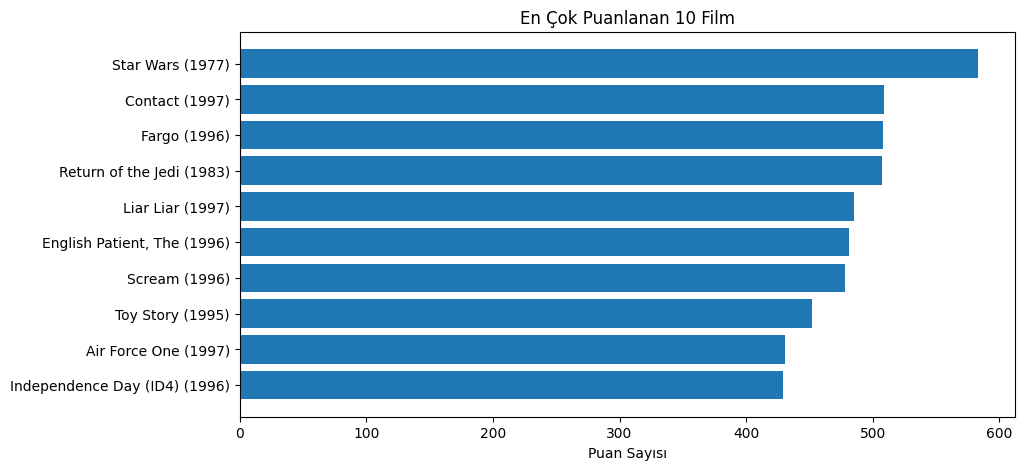

In [20]:
import matplotlib.pyplot as plt

# Spark DF -> Pandas DF
pdf = most_rated_with_titles.limit(10).toPandas()

plt.figure(figsize=(10,5))
plt.barh(pdf['title'], pdf['count'])
plt.gca().invert_yaxis()
plt.title("En Çok Puanlanan 10 Film")
plt.xlabel("Puan Sayısı")
plt.show()
